### Emittance evolution for multiple studies
- Plot the emittance evolution in x and y after sixtracklib tracking along with the theoretical expexted rate.
- The theoretical expected rate is computed from the functions in '../utils/my_functions.py' after defining the machine and the beam parameters in the present script.
- The script can be used for amplitude noise AN and/or phase noise PN.

In [1]:
import sys
sys.path.append('../utils/')
from my_functions import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import pandas as pd

#### Plotting paramerters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 23,
          'axes.titlesize': 23,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize':6,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### 1) Define the type of noise and other simulation parameters

In [3]:
noise_type = 'PN' # 'PN', 'AN'
turns = 1e4
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 
clight = 299792458

#### 2) Compute the theoretical expected rate in m/s

In [4]:
# Machine parameters
betay = 73 # 73 m at CC1, 76 m at CC2
Vcc = 1e6# V
frev = 43.45e3 # Hz
Eb = 270e9 # eV
A = 1e-8 # rms kick in the simulation
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
beta_0 = 0.999999
gamma_0 = 287.7
sigma_z = 0.155
f_CC = 400.789e6 # Hz
#CDeltaA = 0.14
#CDeltaPhi = 0.51
# Compute the PSD in rad^2/Hz
PSD = (A * scale_factor)**2/frev # rad^2/Hz
print(PSD)

1.6777905638665135e-10


In [5]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
C = cmpt_bunch_length_correction_factor(sigma_phi, noise_type)
print(C)

0.5168486015622045


In [6]:
if noise_type == 'PN':
    dey_theoretical = emit_growth_phase_noise(betay, Vcc, frev, Eb, C, PSD)*beta_0*gamma_0 # m/s
else:
    dey_theoretical = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, C , PSD)*beta_0*gamma_0 # m/s
print(dey_theoretical)

2.3582259735020833e-08


#### 3) Load the data for the trasnverse emittance growth from /afs/ and perform the analysis

In [7]:
n_runs = 1 # number of runs that the simulation was repeated

path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/tbt_from_GPUs/'

In [28]:
ey_dict_1 = {} # type: dictionary
ey_dict_2 = {}

for run in range(n_runs):        
    temp_name = 'A{}_run{}'.format(str(A), run) # the suffix of the name of the current study
    # A. load the turn by turn data in a dictionary
    temp_dict_1 = pickle.load( open( path_to_data+'tbt_original_v2.pkl'.format(str(A), run), "rb" ) )
    temp_dict_2 = pickle.load( open( path_to_data+'tbt_reconstructed_v2.pkl'.format(str(A), run), "rb" ) )
    
    # B. Create a different list for each run and save the emittance values
    ey_dict_1[temp_name] = temp_dict_1['neps_y'] # PΝ
    ey_dict_2[temp_name] = temp_dict_2['neps_y']

#### 4) Convert turns to time

In [29]:
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list

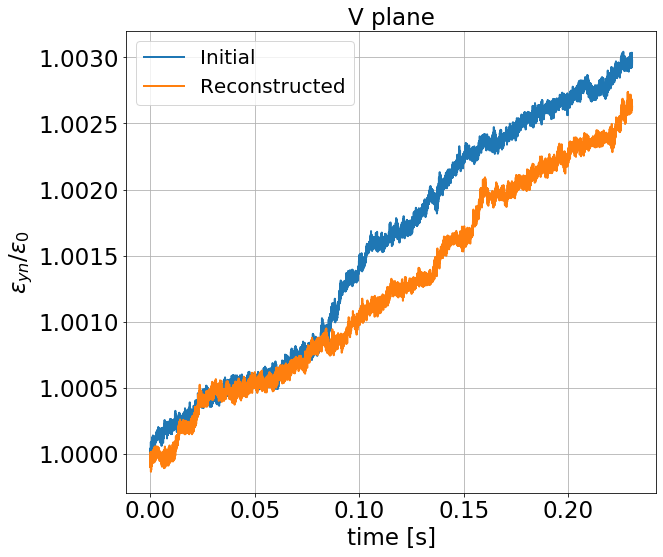

In [30]:
for run in range(n_runs):  
    temp_name = 'A{}_run{}'.format(str(A), run) # the suffix of the name of the current study
    plt.plot(time, ey_dict_1[temp_name]/ey_dict_1[temp_name][0], label='Initial'.format(run))
    plt.plot(time, ey_dict_2[temp_name]/ey_dict_2[temp_name][0], label='Reconstructed'.format(run))
    
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_{yn} / \epsilon_0$')
plt.title('V plane')
plt.legend(loc=0)
plt.grid()

#### 5) Here the mean and the standard deviation of the emittance values are computed over all runs. 

In [31]:
ey_mean_1 = []
ey_mean_2= []

ey_std_1 = []
ey_std_2 = []

for turn in range(int(turns)):
    ey_temp_1 = []
    ey_temp_2 = []

    # keep all the emittance values for all the runs
    for run in range(n_runs):
        temp_name = 'A{}_run{}'.format(str(A), run)
        ey_temp_1.append(ey_dict_1[temp_name][turn])
        ey_temp_2.append(ey_dict_2[temp_name][turn])
    # calculate and append the mean of the emittance value for every turn
    ey_mean_1.append(np.mean(ey_temp_1))
    ey_mean_2.append(np.mean(ey_temp_2))
    # calculate and append the standard deviation of the emittance value for every turn
    ey_std_1.append(np.std(ey_temp_1))    
    ey_std_2.append(np.std(ey_temp_2))    

#### 6a) Plot the evolution of the H, horizontal, emittance

In [12]:
plt.plot(time, ex_mean/ex_mean[0], c='C0')
plt.plot(1,1,c='C0',  label = 'phase noise', linewidth = 3)      
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_n / \epsilon_0$')
plt.title('H plane')
plt.legend(loc=3)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('H_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

NameError: name 'ex_mean' is not defined

#### 6b) Plot the evolution of the V, vertical, emittance

In [32]:
plt.plot(time, np.array(ey_mean)*1e6, c='C0')    
plt.plot(2,2,c='C0',  label = 'phase noise', linewidth = 3)    
plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

NameError: name 'ey_mean' is not defined

#### 7) Plot evolution of the standard deviation $\sigma$ of the emittance values (for the vertical plane)

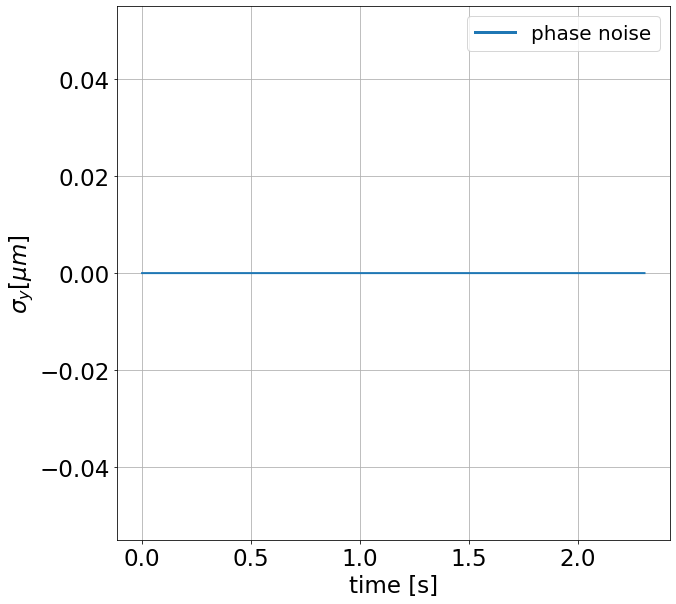

In [18]:
plt.plot(time, np.array(ey_std)*1e6, c='C0')   
plt.plot(0,0,c='C0',  label = 'phase noise', linewidth = 3)   
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_std_270GeV_SPS_noCC_PN1e-8_VRF2_37MV_1e5Nb_1e5turns_mean10runs.png')

#### 8) Compute the emittance growth rate via a linear fit
- Polynomial fit. The degree of the fitting polynomial is 1. 
- V plane only

In [33]:
# linear fit
[m_pn_1, b_pn_1], cov_pn_1 = np.polyfit(time, ey_mean_1, 1, cov=True)
# compute the error of the gradient of the fit slope
err_pn_1 = np.sqrt(np.diag(cov_pn_1))

# linear fit
[m_pn_2, b_pn_2], cov_pn_2 = np.polyfit(time, ey_mean_2, 1, cov=True)
# compute the error of the gradient of the fit slope
err_pn_2 = np.sqrt(np.diag(cov_pn_2))

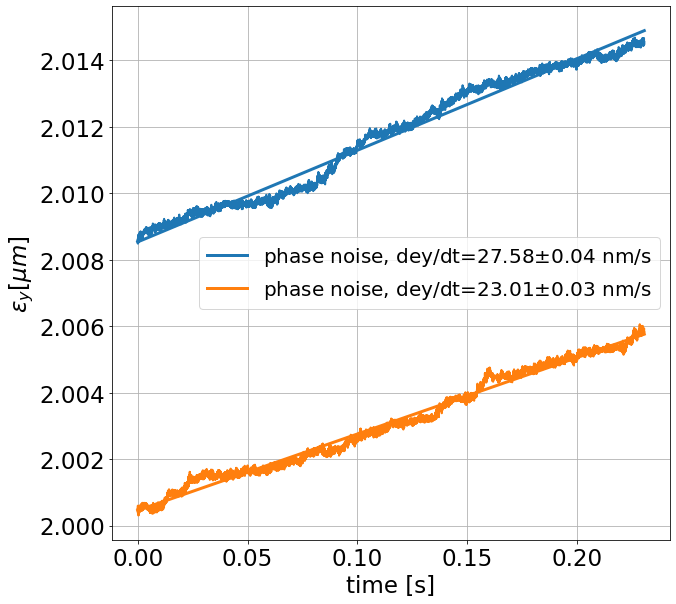

In [34]:
plt.plot(time, np.array(ey_mean_1)*1e6, c='C0')
plt.plot(time, (m_pn_1*time+b_pn_1)*1e6, c = 'C0', label='phase noise, dey/dt={0:.2f}'.format(m_pn_1*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn_1[0]*1e9), linewidth = 3)

plt.plot(time, np.array(ey_mean_2)*1e6, c='C1')
plt.plot(time, (m_pn_2*time+b_pn_2)*1e6, c = 'C1', label='phase noise, dey/dt={0:.2f}'.format(m_pn_2*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn_2[0]*1e9), linewidth = 3)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}runs.png'.format(type_of_noise, n_runs))

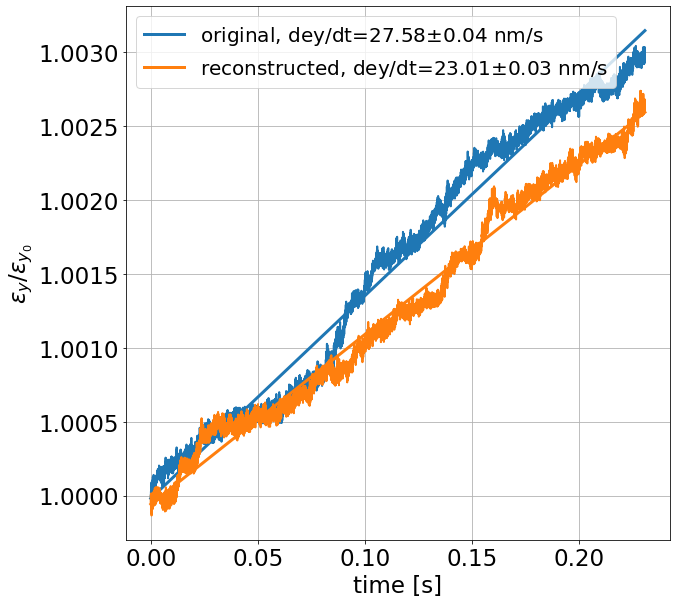

In [35]:
plt.plot(time, np.array(ey_mean_1)/ey_mean_1[0], c='C0')
plt.plot(time, (m_pn_1*time+b_pn_1)/ey_mean_1[0], c = 'C0', label='original, dey/dt={0:.2f}'.format(m_pn_1*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn_1[0]*1e9), linewidth = 3)

plt.plot(time, np.array(ey_mean_2)/ey_mean_2[0], c='C1')
plt.plot(time, (m_pn_2*time+b_pn_2)/ey_mean_2[0], c = 'C1', label='reconstructed, dey/dt={0:.2f}'.format(m_pn_2*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_pn_2[0]*1e9), linewidth = 3)

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y / \epsilon_{y_0} $')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}runs.png'.format(noise_type, n_runs))

#### 9) Plot fill between

In [37]:
if type_of_noise == 'PN':
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
else:
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'

#### A) y axis emittance values

NameError: name 'dey_theoretical' is not defined

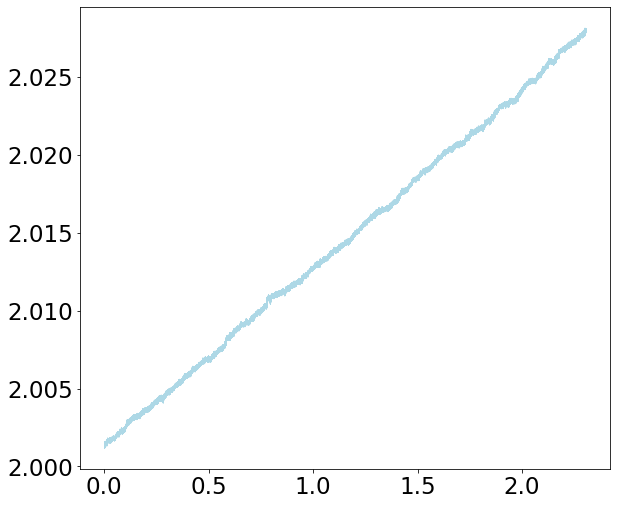

In [38]:
# std over all runs
plt.fill_between(time, np.array(ey_mean)*1e6 - np.array(ey_std)*1e6, np.array(ey_mean)*1e6 + np.array(ey_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (dey_theoretical*time+b_pn)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={0:.2f} nm/s'.format(dey_theoretical*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m_pn*time+b_pn)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.4f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.ylim(1.98, 2.02)
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('V_emittance_growth_rate_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between_v2.png'.format(type_of_noise, n_runs))

#### B) y axis: emittance values after substracting the initial emittance

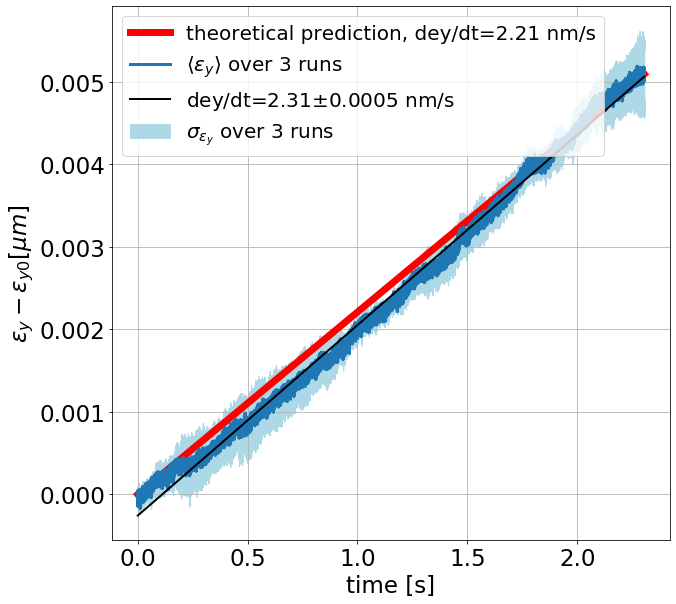

In [29]:
initial_std = ey_std[0]
initial_mean_emittance = ey_mean[0]
# std over all runs
plt.fill_between(time, np.array(ey_mean-initial_mean_emittance )*1e6 - np.array(ey_std-initial_std)*1e6, np.array(ey_mean-initial_mean_emittance)*1e6 + np.array(ey_std-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(time, (dey_theoretical*time)*1e6, c='r', linewidth=7, label='theoretical prediction, dey/dt={0:.2f} nm/s'.format(dey_theoretical*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(time, np.array(ey_mean-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(time, (m_pn*time+b_pn-initial_mean_emittance)*1e6, c = 'k', label='dey/dt={0:.2f}'.format(m_pn*1e9)+'$\pm$'+'{0:.4f} nm/s'.format(err_pn[0]*1e9), linewidth = 2)



plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(0, 0.01)
plt.tight_layout()

savefig = True
if savefig:
    plt.savefig('V_emit_growth_rate_substract_initial_emittance_270GeV_SPS_noCC_{}1e-8_VRF2_37MV_1e5Nb_1e5turns_mean{}run_fill_between.png'.format(type_of_noise, n_runs))